In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import mixedlm
from statsmodels.stats.anova import AnovaRM
import seaborn as sns

In [93]:
# Paths to sidd's local CSV files
reaction_time_csvs = [
    r'F:\Human Centered AI\4th Semester+Thesis\02455 Experiment in Coginitive Science\CognitiveScience-main_281123\silence_avg_rt.csv',
    r'F:\Human Centered AI\4th Semester+Thesis\02455 Experiment in Coginitive Science\CognitiveScience-main_281123\pink_avg_rt.csv',
    r'F:\Human Centered AI\4th Semester+Thesis\02455 Experiment in Coginitive Science\CognitiveScience-main_281123\brown_avg_rt.csv'
]

correctness_csvs = [
    r'F:\Human Centered AI\4th Semester+Thesis\02455 Experiment in Coginitive Science\CognitiveScience-main_281123\brown_avg_corr.csv',
    r'F:\Human Centered AI\4th Semester+Thesis\02455 Experiment in Coginitive Science\CognitiveScience-main_281123\pink_avg_corr.csv',
    r'F:\Human Centered AI\4th Semester+Thesis\02455 Experiment in Coginitive Science\CognitiveScience-main_281123\silence_avg_corr.csv'
]

# Function to combine CSV files
def combine_csv(files, value_name):
    combined_df = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file)
        # Extract noise condition from file path
        noise_condition = file.split('/')[0].split('_')[2]
        df['Data Type'] = noise_condition
        df.rename(columns={'Value': value_name}, inplace=True)
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

# Combine the reaction time CSV files
combined_reaction_time_df = combine_csv(reaction_time_csvs, 'ReactionTime')

# Combine the correctness CSV files
combined_correctness_df = combine_csv(correctness_csvs, 'Correctness')

# Save the combined DataFrames to new CSV files
combined_reaction_time_df.to_csv('combined_reaction_time.csv', index=False)
combined_correctness_df.to_csv('combined_correctness.csv', index=False)


In [77]:
combined_correctness_df.head()

,index,participant,session,is_correct,Data Type
0,0,200,brown,0.989583,avg
1,3,201,brown,0.989583,avg
2,6,202,brown,0.979167,avg
3,9,203,brown,0.979167,avg
4,12,204,brown,0.979167,avg


In [78]:
combined_reaction_time_df.head()

,index,participant,session,rt,Data Type
0,2,200,silence,0.689830,avg
1,5,201,silence,0.691080,avg
2,8,202,silence,0.706021,avg
3,11,203,silence,0.561180,avg
4,14,204,silence,0.713385,avg


In [79]:
# Descriptive statistics for reaction time
reaction_time_descriptive_stats = combined_reaction_time_df.groupby('session')['rt'].describe()

# Descriptive statistics for correctness
correctness_descriptive_stats = combined_correctness_df.groupby('session')['is_correct'].describe()

# Display the results
print("Descriptive Statistics for Reaction Time:")
print(reaction_time_descriptive_stats)
print("\nDescriptive Statistics for Correctness:")
print(correctness_descriptive_stats)


Descriptive Statistics for Reaction Time:
         count      mean       std       min       25%       50%       75%  \
session                                                                      
brown     13.0  0.592641  0.084749  0.416473  0.548970  0.583730  0.647683   
pink      13.0  0.599196  0.091951  0.464459  0.542763  0.587469  0.658994   
silence   13.0  0.610020  0.085092  0.464950  0.556076  0.615820  0.689830   

              max  
session            
brown    0.764905  
pink     0.806334  
silence  0.713385  

Descriptive Statistics for Correctness:
         count      mean       std       min       25%       50%       75%  \
session                                                                      
brown     13.0  0.971955  0.019200  0.937500  0.968750  0.979167  0.989583   
pink      13.0  0.969551  0.027383  0.895833  0.958333  0.968750  0.989583   
silence   13.0  0.959135  0.031954  0.906250  0.937500  0.968750  0.979167   

              max  
session        

## Reaction Time

- **Count**: There are 13 observations for each noise condition.
- **Mean Reaction Time**:
  - **Brown**: Approximately 0.593 seconds.
  - **Pink**: Approximately 0.599 seconds.
  - **Silence**: Approximately 0.610 seconds.
- **Standard Deviation**: The reaction times have a relatively low standard deviation in all conditions, indicating that the data points are fairly close to the mean.
- **Min and Max**: Reaction times range from about 0.416 to 0.806 seconds across all conditions.
- **Median (50%)**: The median reaction time is slightly lower in brown and pink noise conditions compared to silence.

## Correctness

- **Mean Correctness**:
  - **Brown**: Approximately 97.2%.
  - **Pink**: Approximately 97.0%.
  - **Silence**: Approximately 95.9%.
- **Standard Deviation**: The standard deviation for correctness is very low in all conditions, suggesting that most participants had high correctness rates with little variability.
- **Min and Max**: Correctness ranges from about 89.6% to 100% across all conditions.


In [80]:
# Perform Shapiro-Wilk Normality Test
def test_normality(data, group_col, value_col):
    normality_results = {}
    for group in data[group_col].unique():
        group_data = data[data[group_col] == group][value_col]
        stat, p = shapiro(group_data)
        normality_results[group] = p
    return normality_results

# Perform Levene's Test for Homoscedasticity
def test_homoscedasticity(data, group_col, value_col):
    group_data = [data[data[group_col] == group][value_col] for group in data[group_col].unique()]
    stat, p = levene(*group_data)
    return p

# Reaction Time Data
normality_reaction_time = test_normality(combined_reaction_time_df, 'session', 'rt')
homoscedasticity_reaction_time = test_homoscedasticity(combined_reaction_time_df, 'session', 'rt')

# Correctness Data
normality_correctness = test_normality(combined_correctness_df, 'session', 'is_correct')
homoscedasticity_correctness = test_homoscedasticity(combined_correctness_df, 'session', 'is_correct')

# Print results
print("Normality Test - Reaction Time:", normality_reaction_time)
print("Homoscedasticity Test - Reaction Time:", homoscedasticity_reaction_time)
print("Normality Test - Correctness:", normality_correctness)
print("Homoscedasticity Test - Correctness:", homoscedasticity_correctness)


Normality Test - Reaction Time: {'silence': 0.27660563588142395, 'pink': 0.6252250075340271, 'brown': 0.8806359171867371}
Homoscedasticity Test - Reaction Time: 0.8288030418038222
Normality Test - Correctness: {'brown': 0.009797077625989914, 'pink': 0.012461088597774506, 'silence': 0.2837666869163513}
Homoscedasticity Test - Correctness: 0.1480747007103196


In [81]:
# One-Way Repeated Measures ANOVA for Reaction Time
anova_reaction_time = AnovaRM(data=combined_reaction_time_df, depvar='rt', 
                              subject='participant', within=['session']).fit()

# Friedman Test for Correctness
friedman_correctness = stats.friedmanchisquare(combined_correctness_df[combined_correctness_df['session'] == 'silence']['is_correct'],
                                               combined_correctness_df[combined_correctness_df['session'] == 'pink']['is_correct'],
                                               combined_correctness_df[combined_correctness_df['session'] == 'brown']['is_correct'])

anova_reaction_time.summary(), friedman_correctness


(<class 'statsmodels.iolib.summary2.Summary'>
 """
                 Anova
         F Value Num DF  Den DF Pr > F
 -------------------------------------
 session  0.7039 2.0000 24.0000 0.5046
 
 """,
 FriedmanchisquareResult(statistic=0.31111111111111617, pvalue=0.8559395234122631))

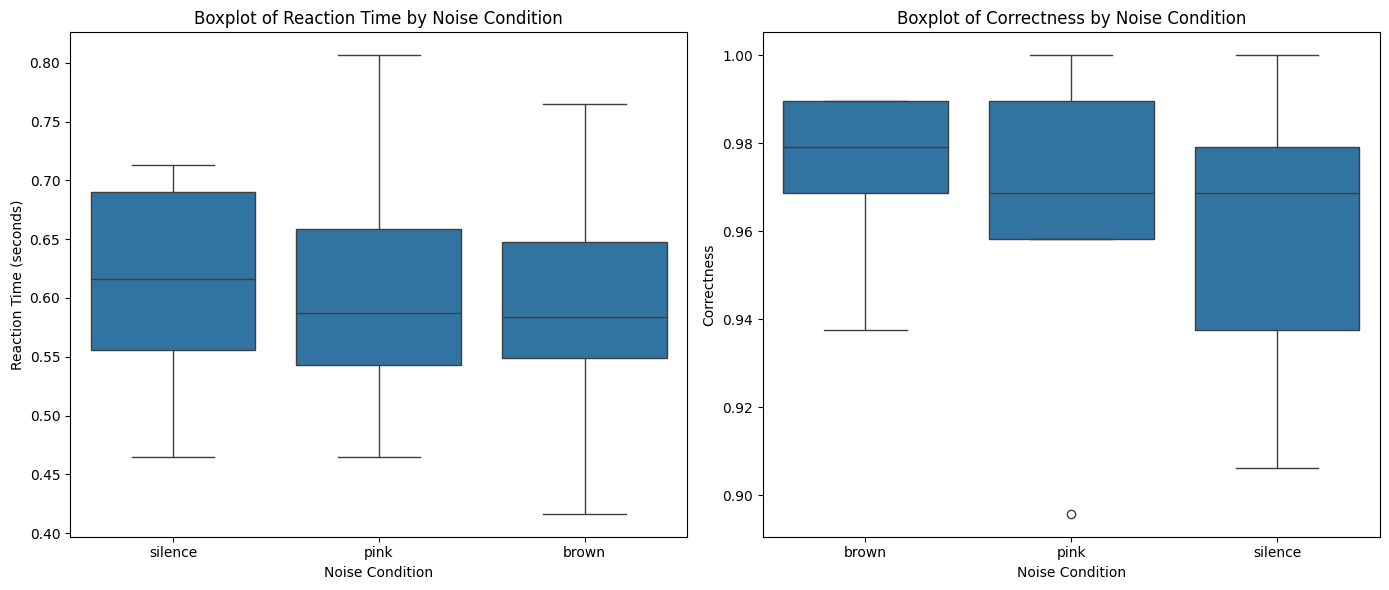

In [82]:
# Boxplots for Reaction Time and Correctness by Noise Condition
plt.figure(figsize=(14, 6))

# Reaction Time Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='session', y='rt', data=combined_reaction_time_df)
plt.title('Boxplot of Reaction Time by Noise Condition')
plt.xlabel('Noise Condition')
plt.ylabel('Reaction Time (seconds)')

# Correctness Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x='session', y='is_correct', data=combined_correctness_df)
plt.title('Boxplot of Correctness by Noise Condition')
plt.xlabel('Noise Condition')
plt.ylabel('Correctness')

plt.tight_layout()
plt.show()

# Analysis of Reaction Times and Correctness Across Noise Conditions

## Boxplot of Reaction Time by Noise Condition

### Median Reaction Time
- The medians are consistent across conditions, indicating no substantial impact from noise type on central reaction times.

### Interquartile Range (IQR)
- Similar IQRs across silence, pink, and brown noise suggest consistent within-group variability and a similar spread of reaction times.

### Outliers
- No outliers in reaction time data point to a homogeneous response among participants across different noise conditions.

### Range of Reaction Times
- Slight variability in the range across conditions, with the widest range observed in silence, may indicate subtle differences in participant performance.

### Overall Observations
- Reaction times do not vary significantly with noise condition changes, which aligns with the ANOVA results indicating no significant effect.

## Boxplot of Correctness by Noise Condition

### Median Correctness
- Median correctness is slightly higher in pink noise compared to other conditions, but not markedly so.

### Interquartile Range (IQR)
- Narrow IQRs suggest tight clustering of participant scores around the median, indicating consistent performance.

### Outliers
- At least one outlier in pink noise could reflect an individual difference in response to this condition.

### Range of Correctness
- A broader range in silence suggests more variability in performance without noise, possibly indicating individual preferences for a level of background noise.

### Overall Observations
- Despite some individual variability, there is no clear evidence that any noise condition consistently results in higher correctness scores.

## Key takeaways

- The consistent distribution across conditions implies the cognitive tasks are resilient to changes in auditory environment.
- Absence of significant differences supports ANOVA findings, suggesting noise conditions do not significantly affect performance.
- Consideration of individual differences, task difficulty, and ceiling effects is crucial for a comprehensive interpretation of these results.


C:\Users\siddh\AppData\Local\Temp\ipykernel_9588\2289225158.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='session', y='rt', data=combined_reaction_time_df, ci="sd")
C:\Users\siddh\AppData\Local\Temp\ipykernel_9588\2289225158.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='session', y='is_correct', data=combined_correctness_df, ci="sd")


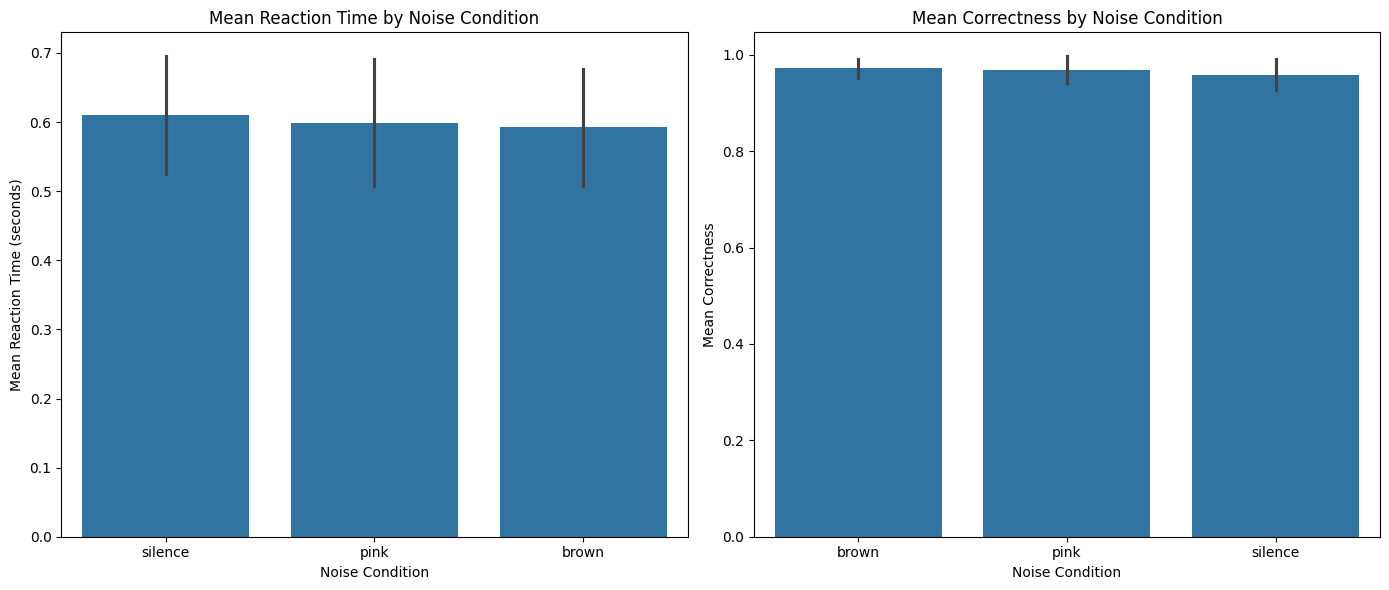

In [158]:
# Mean Reaction Time and Correctness with Error Bars
plt.figure(figsize=(14, 6))

# Mean Reaction Time
plt.subplot(1, 2, 1)
sns.barplot(x='session', y='rt', data=combined_reaction_time_df, ci="sd")
plt.title('Mean Reaction Time by Noise Condition')
plt.xlabel('Noise Condition')
plt.ylabel('Mean Reaction Time (seconds)')

# Mean Correctness
plt.subplot(1, 2, 2)
sns.barplot(x='session', y='is_correct', data=combined_correctness_df, ci="sd")
plt.title('Mean Correctness by Noise Condition')
plt.xlabel('Noise Condition')
plt.ylabel('Mean Correctness')

plt.tight_layout()
plt.show()

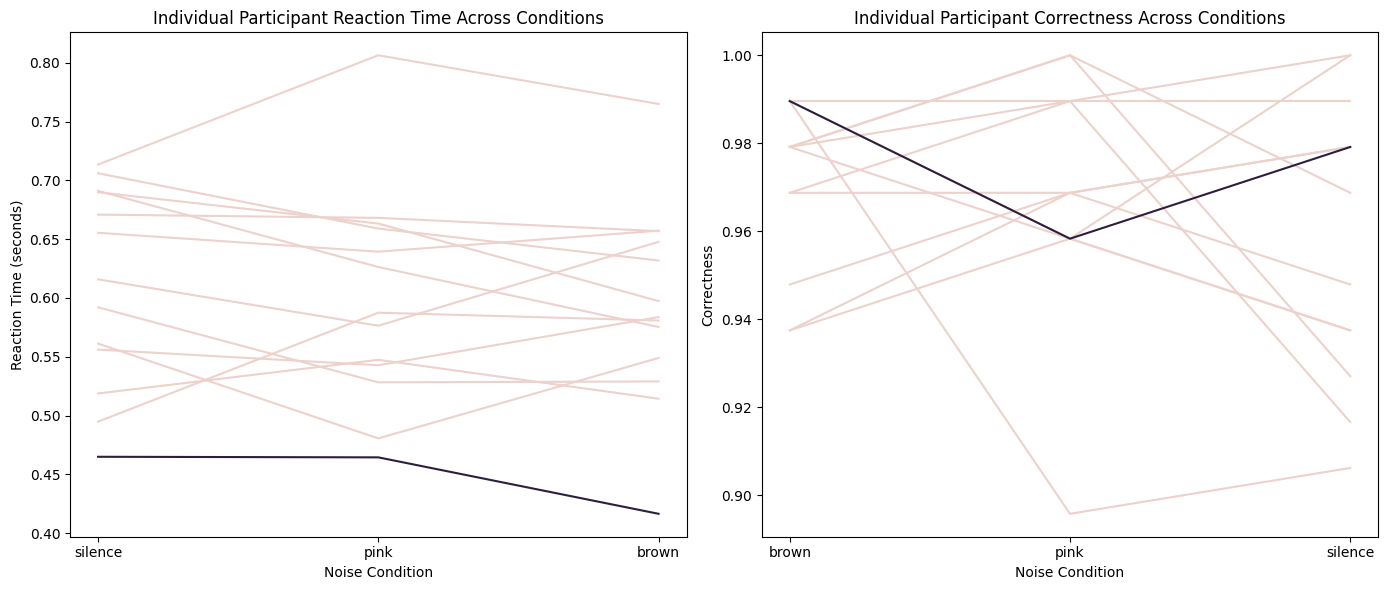

In [84]:
# Individual Participant Performance Across Conditions
plt.figure(figsize=(14, 6))

# Individual Participant Reaction Time
plt.subplot(1, 2, 1)
sns.lineplot(x='session', y='rt', hue='participant', data=combined_reaction_time_df, legend=False)
plt.title('Individual Participant Reaction Time Across Conditions')
plt.xlabel('Noise Condition')
plt.ylabel('Reaction Time (seconds)')

# Individual Participant Correctness
plt.subplot(1, 2, 2)
sns.lineplot(x='session', y='is_correct', hue='participant', data=combined_correctness_df, legend=False)
plt.title('Individual Participant Correctness Across Conditions')
plt.xlabel('Noise Condition')
plt.ylabel('Correctness')

plt.tight_layout()
plt.show()

# Reaction Time and Correctness Across Noise Conditions

## Reaction Time Graph Analysis

### Trends
- Most individual lines show little variation in reaction times across noise conditions, suggesting minimal impact from the different types of noise.

### Outliers
- A single participant (bold black line) exhibits a significant decrease in reaction time from silence to pink to brown noise, indicating a unique response to auditory conditions.

### Overall Pattern
- There is no consistent increase or decrease in reaction time across conditions for the majority of participants, aligning with ANOVA results showing no significant effect of noise conditions.

### Variability
- Individual variability in reaction times is present but not systematic, pointing to personal differences in response to noise conditions.

## Correctness Graph Analysis

### Trends
- Lines on the graph indicate variability in correctness across noise conditions, with some participants performing better in silence and others in noise.

### Performance Consistency
- High correctness scores (above 0.90) suggest that the task may not have been challenging enough to elicit variation in performance based on noise condition.

### Noisy Conditions
- Some participants show slightly better correctness in pink or brown noise than in silence, suggesting individual differences in how noise affects performance.

### Overall Pattern
- No clear pattern emerges for one noise condition consistently leading to higher correctness, which is supported by the ANOVA results indicating no significant differences.

## Detailed Observations

### Individual Differences
- The graphs highlight individual variability, likely due to personal preferences, noise sensitivity, or task nature.

### Lack of a Clear Group Trend
- No group-level trend suggests superiority or inferiority of any noise condition in terms of reaction time or correctness.

### Task Difficulty
- The high correctness scores across all conditions may indicate that the task was not sufficiently challenging to differentiate performance based on noise condition.


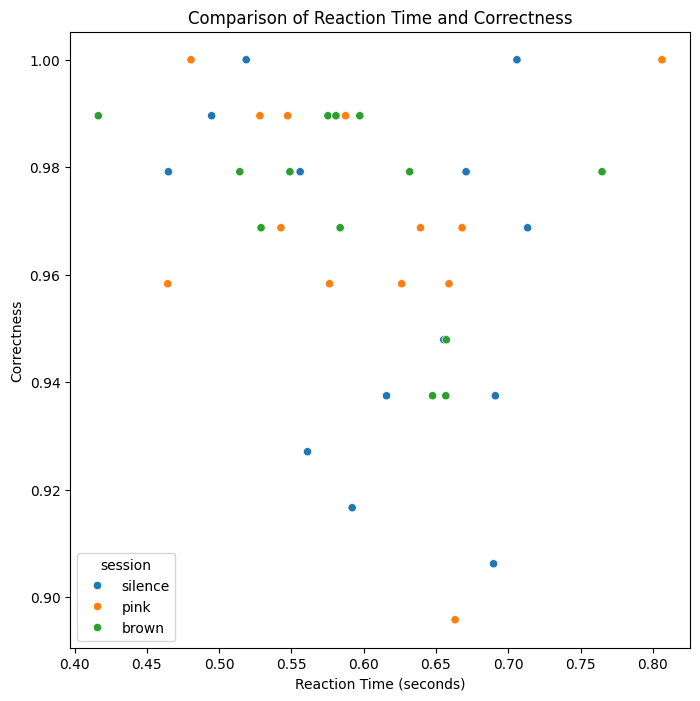

In [152]:
# Comparison of Reaction Time and Correctness
plt.figure(figsize=(8, 8))
sns.scatterplot(x='rt', y='is_correct', hue='session', data=combined_reaction_time_df.merge(combined_correctness_df, on=['participant', 'session']))
plt.title('Comparison of Reaction Time and Correctness')
plt.xlabel('Reaction Time (seconds)')
plt.ylabel('Correctness')

plt.show()

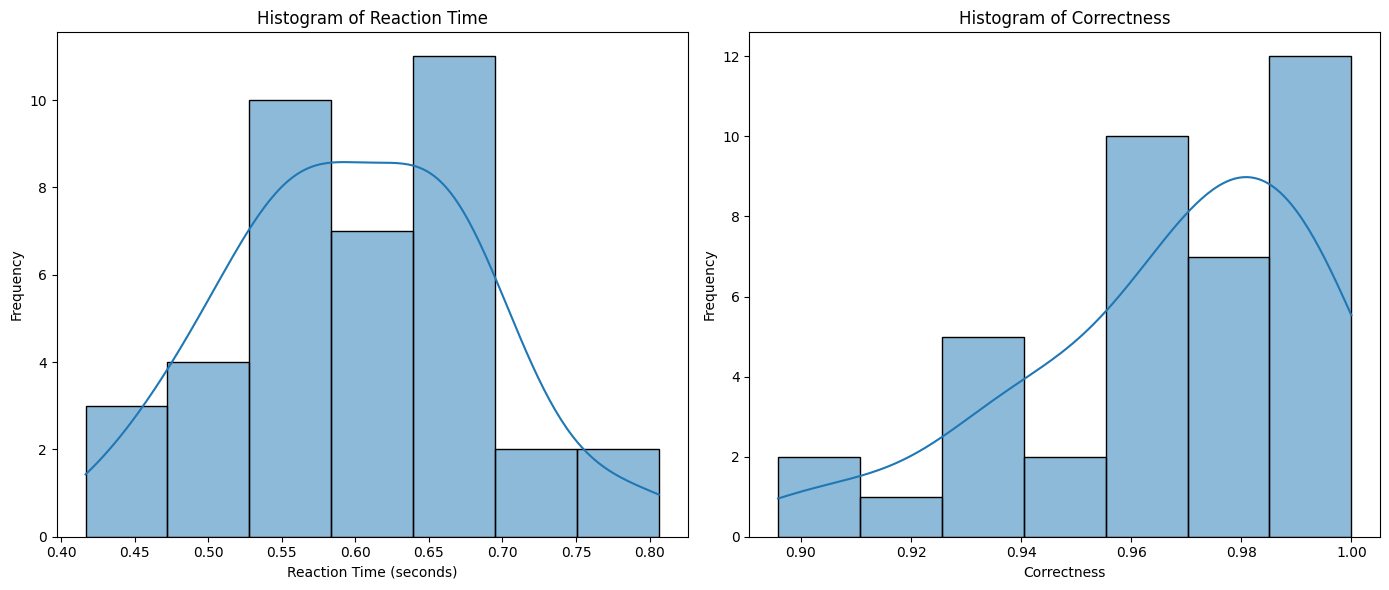

In [86]:
# Histograms for Reaction Time and Correctness
plt.figure(figsize=(14, 6))

# Histogram of Reaction Time
plt.subplot(1, 2, 1)
sns.histplot(combined_reaction_time_df['rt'], kde=True)
plt.title('Histogram of Reaction Time')
plt.xlabel('Reaction Time (seconds)')
plt.ylabel('Frequency')

# Histogram of Correctness
plt.subplot(1, 2, 2)
sns.histplot(combined_correctness_df['is_correct'], kde=True)
plt.title('Histogram of Correctness')
plt.xlabel('Correctness')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

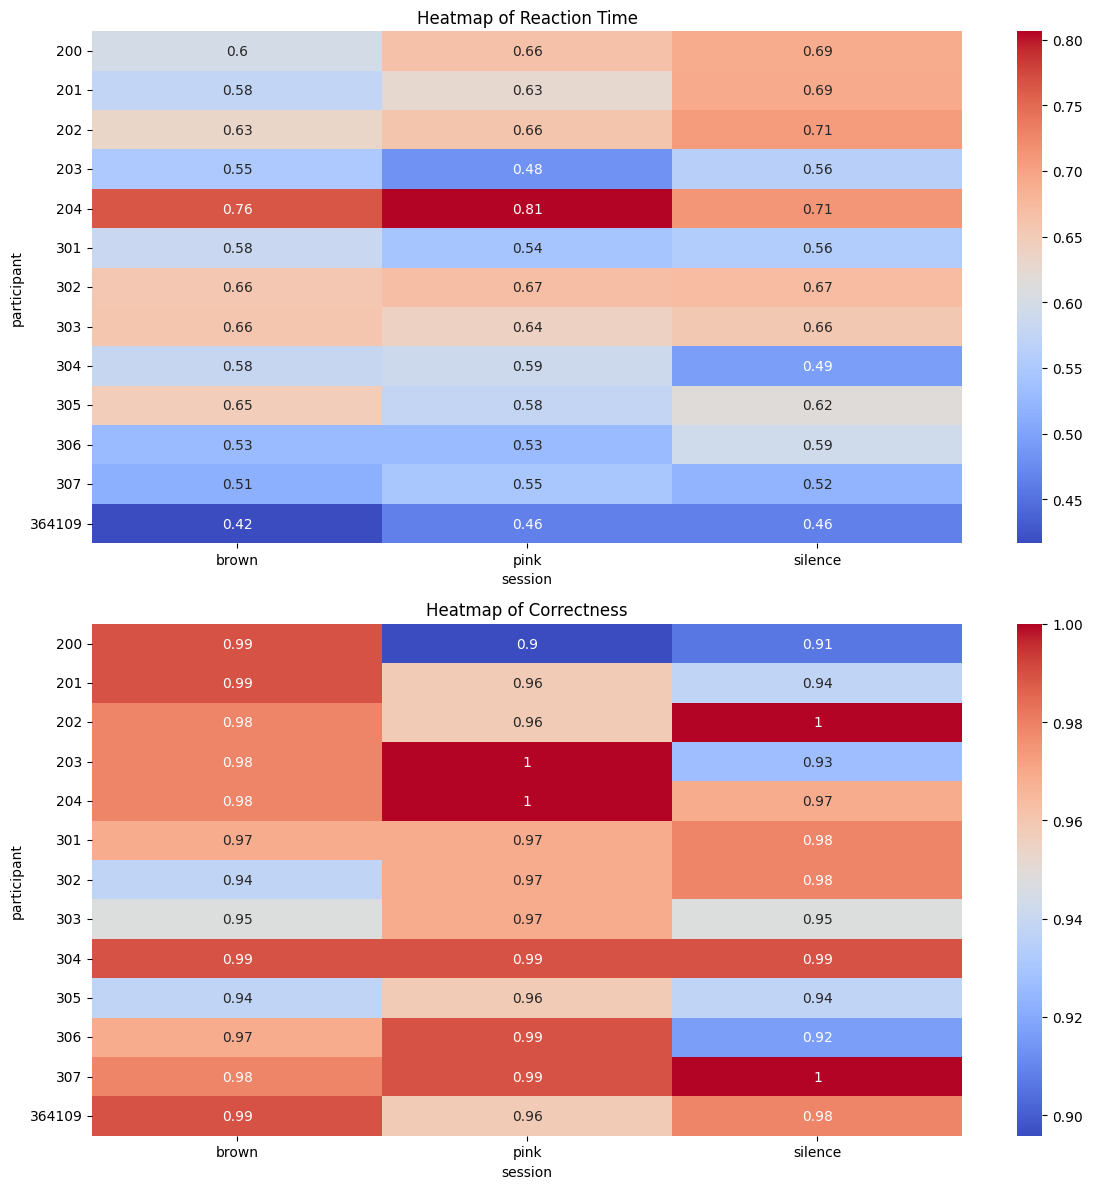

In [87]:
# Create pivot tables for reaction time and correctness
rt_pivot = combined_reaction_time_df.pivot_table(index="participant", columns="session", values="rt")
corr_pivot = combined_correctness_df.pivot_table(index="participant", columns="session", values="is_correct")

# Set up the matplotlib figure
plt.figure(figsize=(12, 12))

# Heatmap for Reaction Time
plt.subplot(2, 1, 1)
sns.heatmap(rt_pivot, annot=True, cmap="coolwarm")
plt.title('Heatmap of Reaction Time')

# Heatmap for Correctness
plt.subplot(2, 1, 2)
sns.heatmap(corr_pivot, annot=True, cmap="coolwarm")
plt.title('Heatmap of Correctness')

plt.tight_layout()
plt.show()


## Heatmap Visualizations

### Heatmap of Reaction Time

#### What it Represents
This heatmap visualizes the reaction time for each participant under different noise conditions (silence, pink, brown).

#### Layout
- **Rows**: Each row represents an individual participant.
- **Columns**: Each column corresponds to one of the noise conditions.

#### Color Coding
The colors in the heatmap indicate the reaction time, with the color scale (coolwarm) showing variation from lower (cool colors like blue) to higher reaction times (warm colors like red).

#### Interpretation
You can observe patterns and differences in reaction time across different noise conditions for each participant. Areas of the heatmap with warmer colors indicate longer reaction times, while cooler colors indicate shorter reaction times. Predominant colors in a column suggest a trend in reaction time for that particular noise condition.

### Heatmap of Correctness

#### What it Represents
This heatmap displays the correctness of responses for each participant under different noise conditions.

#### Layout
- **Rows**: Each row is an individual participant.
- **Columns**: Each column represents a noise condition.

#### Color Coding
The color scale illustrates the correctness rate. Cooler colors indicate lower correctness rates, while warmer colors indicate higher correctness rates.

#### Interpretation
This plot allows you to see how accurate participants were under each noise condition. Consistent color patterns across a column would suggest a general trend in correctness for that specific noise environment.


## Heatmap of Reaction Time - Key Observations
- **Variability Across Participants:** Reaction times show variability but no consistent trend per noise condition.
- **Reaction Time Range:** Times range from 0.42 to 0.81 seconds, with most falling in a moderate range.
- **Color Gradient:** A gradient from blue to red represents faster to slower reaction times, respectively.

## Heatmap of Correctness - Key Observations
- **High Correctness Rates:** Participants exhibit high correctness rates across all noise conditions, shown by the prevalence of red.
- **Perfect Scores:** Many participants achieve perfect scores, indicating a high level of correctness.
- **Few Lower Scores:** Instances of lower correctness rates are present but not concentrated within any specific noise condition.


In [88]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming the combined dataframes have already been created and are named as follows:
# combined_reaction_time_df for reaction times
# combined_correctness_df for correctness
# Both dataframes include 'participant' as the identifier and 'session' for the noise conditions

# ANOVA for Reaction Time
anova_rt = ols('rt ~ C(session)', data=combined_reaction_time_df).fit()
anova_rt_table = sm.stats.anova_lm(anova_rt, typ=2)

# ANOVA for Correctness
anova_corr = ols('is_correct ~ C(session)', data=combined_correctness_df).fit()
anova_corr_table = sm.stats.anova_lm(anova_corr, typ=2)

anova_rt_table, anova_corr_table


(              sum_sq    df         F   PR(>F)
 C(session)  0.002003   2.0  0.131303  0.87737
 Residual    0.274536  36.0       NaN      NaN,
               sum_sq    df         F   PR(>F)
 C(session)  0.001207   2.0  0.846554  0.43725
 Residual    0.025674  36.0       NaN      NaN)

# ANOVA Results and Interpretation

## Experiment Context
This experiment investigates the impact of different noise conditions (silence, pink noise, and brown noise) on reaction time and correctness.

## ANOVA Results Variables

### Sum of Squares (sum_sq)
- **Definition**: Represents the total variation in the data. A larger sum_sq indicates a greater amount of variance explained by the factor.
- **Reaction Time**: 0.002003, indicating low variance in reaction times explained by the session type.
- **Correctness**: 0.001207, also indicating little variance in correctness explained by the session type.

### Degrees of Freedom (df)
- **Definition**: The number of values in the final calculation of a statistic that are free to vary.
- **For Both Tests**: 2 df for the session, suggesting the comparison of three different conditions.

### F-value (F)
- **Definition**: The ratio of the variance explained by the factor to the variance within groups (residual). Higher F-values typically suggest a more significant effect.
- **Reaction Time**: 0.131303, a low F-value indicating a weak effect of session type on reaction times.
- **Correctness**: 0.846554, also a low value, suggesting a weak effect on correctness.

### P-value (PR(>F))
- **Definition**: Indicates the probability of observing the data, or something more extreme, if the null hypothesis is true. A low P-value (<0.05) indicates statistical significance.
- **Reaction Time**: 0.87737, well above 0.05, showing no significant effect of session type on reaction times.
- **Correctness**: 0.43725, also above 0.05, indicating no significant effect on correctness.

## Experiment Conclusion
The type of noise condition (silence, pink, or brown noise) does not have a statistically significant impact on either the reaction times or the correctness of the responses of the participants. This implies that these different auditory environments do not alter these specific cognitive performance aspects in a measurable way.


# ANOVA Results and Interpretation

## Experiment Context
This experiment investigates the impact of different noise conditions (silence, pink noise, and brown noise) on reaction time and correctness.

## ANOVA Results Variables

## Sum of Squares (sum_sq)
- **Definition**: Represents the total variation in the data. A larger sum_sq indicates a greater amount of variance explained by the factor.
- **Reaction Time**: 0.002003, indicating low variance in reaction times explained by the session type.
- **Correctness**: 0.001207, also indicating little variance in correctness explained by the session type.

## Degrees of Freedom (df)
- **Definition**: The number of values in the final calculation of a statistic that are free to vary.
- **For Both Tests**: 2 df for the session, suggesting the comparison of three different conditions.

## F-value (F)
- **Definition**: The ratio of the variance explained by the factor to the variance within groups (residual). Higher F-values typically suggest a more significant effect.
- **Reaction Time**: 0.131303, a low F-value indicating a weak effect of session type on reaction times.
- **Correctness**: 0.846554, also a low value, suggesting a weak effect on correctness.

## P-value (PR(>F))
- **Definition**: Indicates the probability of observing the data, or something more extreme, if the null hypothesis is true. A low P-value (<0.05) indicates statistical significance.
- **Reaction Time**: 0.87737, well above 0.05, showing no significant effect of session type on reaction times.
- **Correctness**: 0.43725, also above 0.05, indicating no significant effect on correctness.

# Interpretation of ANOVA Results

## Experiment Overview
The experiment examines the impact of different noise conditions (silence, pink noise, and brown noise) on participants' reaction time and correctness.

## ANOVA Results Interpretation

## Reaction Time
- **P-value**: 0.87737
- **Interpretation**: The high P-value indicates that differences in reaction times across different sessions are not statistically significant. This suggests that the type of noise condition does not meaningfully impact reaction time.

## Correctness
- **P-value**: 0.43725
- **Interpretation**: Similar to reaction time, the high P-value here suggests that the correctness of responses does not significantly differ across the sessions. This indicates that the session condition (type of noise) does not have a significant impact on the accuracy of participants' responses.

## Overall
- The high P-values in both tests suggest that the session conditions (silence, pink noise, and brown noise) do not have a statistically significant effect on either reaction time or correctness. 
- This implies that, based on the data collected, changing the noise conditions in the sessions does not lead to meaningful changes in these cognitive performance outcomes.



## Experiment Conclusion
The type of noise condition (silence, pink, or brown noise) does not have a statistically significant impact on either the reaction times or the correctness of the responses of the participants. This implies that these different auditory environments do not alter these specific cognitive performance aspects in a measurable way.


# Alternate Statistics - LMM/GLMM with normality, sphericity check

In [132]:
combined_df_new = pd.read_csv(r'F:\Human Centered AI\4th Semester+Thesis\02455 Experiment in Coginitive Science\CognitiveScience-main_final\CognitiveScience\combined_df_new.csv')

In [133]:
# Data Cleaning
# Convert 'is_correct' from 10 to 1, and assume that blank spaces are 0
combined_df_new['is_correct'] = combined_df_new['is_correct'].replace(10, 1).fillna(0)

# Convert 'nback_type' from 10,20 to 1,2
combined_df_new['nback_type'] = combined_df_new['nback_type'].replace({10: 1, 20: 2})

# Inspect the 'rt' values to understand their format
print("Sample 'rt' values before conversion:\n", combined_df_new['rt'].head(10))

combined_df_new['rt'] = combined_df_new['rt'].str.split(',').str[0].str.strip('[]').astype(float)


Sample 'rt' values before conversion:
 0                      NaN
1    [0.42141750000882894]
2                      NaN
3    [0.47623529203701764]
4                      NaN
5                      NaN
6                      NaN
7                      NaN
8                      NaN
9     [0.7008402909850702]
Name: rt, dtype: object


In [134]:
combined_df_new.head()


,response,is_correct,nback_type,rt,participant,session,date
0,NaN,1.0,1.0,NaN,200,brown,2023-11-18_15h27.51.073
1,['space'],1.0,1.0,0.421418,200,brown,2023-11-18_15h27.51.073
2,NaN,1.0,1.0,NaN,200,brown,2023-11-18_15h27.51.073
3,['space'],1.0,1.0,0.476235,200,brown,2023-11-18_15h27.51.073
4,NaN,1.0,1.0,NaN,200,brown,2023-11-18_15h27.51.073


In [140]:
# Normality Test
normality_results_reactiontime = {session: shapiro(combined_df_new.loc[combined_df_new['session'] == session, 'rt'].dropna())[1]
                     for session in combined_df_new['session'].unique()}

# Homoscedasticity Test
homoscedasticity_result_reactiontime = levene(
    combined_df_new.loc[combined_df_new['session'] == 'brown', 'rt'].dropna(),
    combined_df_new.loc[combined_df_new['session'] == 'pink', 'rt'].dropna(),
    combined_df_new.loc[combined_df_new['session'] == 'silence', 'rt'].dropna()
)[1]

# Print the normality and homoscedasticity test results
print("Normality Test Results:", normality_results_reactiontime)
print("Homoscedasticity Test Result:", homoscedasticity_result_reactiontime)

# Normality Test for Correctness
normality_results_correctness = {
    session: shapiro(combined_df_new.loc[combined_df_new['session'] == session, 'is_correct'].dropna())[1]
    for session in combined_df_new['session'].unique()
}

# Homoscedasticity Test for Correctness
homoscedasticity_result_correctness = levene(
    combined_df_new.loc[combined_df_new['session'] == 'brown', 'is_correct'].dropna(),
    combined_df_new.loc[combined_df_new['session'] == 'pink', 'is_correct'].dropna(),
    combined_df_new.loc[combined_df_new['session'] == 'silence', 'is_correct'].dropna()
)[1]

normality_results_correctness, homoscedasticity_result_correctness


Normality Test Results: {'brown': 4.632878263886469e-21, 'pink': 1.1228254061045987e-23, 'silence': 1.6224945577509284e-23}
Homoscedasticity Test Result: 0.9556426744279467


({'brown': 0.0, 'pink': 0.0, 'silence': 0.0}, 0.5727446279006682)

## Normality Test for Correctness:

- For all noise conditions (brown, pink, silence), the p-values are 0.0. This strongly suggests that the correctness data does not follow a normal distribution for any of the noise conditions.

## Homoscedasticity Test for Correctness:

- The p-value is 0.5727446279006682, which is greater than the typical alpha level of 0.05. This suggests that the variances of correctness are equal across the three noise conditions, indicating homoscedasticity.

In [141]:
# Descriptive Statistics for Reaction Time
desc_stats_rt = combined_df_new.groupby('session')['rt'].describe()

# Descriptive Statistics for Correctness
desc_stats_correctness = combined_df_new.groupby('session')['is_correct'].describe()

# Print the results
print("Descriptive Statistics for Reaction Time:")
print(desc_stats_rt)
print("\nDescriptive Statistics for Correctness:")
print(desc_stats_correctness)


Descriptive Statistics for Reaction Time:
         count      mean       std       min       25%       50%       75%  \
session                                                                      
brown    432.0  0.590578  0.201264  0.192569  0.456358  0.530476  0.673607   
pink     444.0  0.598663  0.210727  0.354135  0.462968  0.529056  0.667960   
silence  433.0  0.607947  0.207427  0.350721  0.475746  0.552323  0.680408   

              max  
session            
brown    1.655839  
pink     1.778665  
silence  2.011369  

Descriptive Statistics for Correctness:
          count      mean       std  min  25%  50%  75%  max
session                                                     
brown    1352.0  0.897189  0.303824  0.0  1.0  1.0  1.0  1.0
pink     1352.0  0.894970  0.306705  0.0  1.0  1.0  1.0  1.0
silence  1352.0  0.885355  0.318711  0.0  1.0  1.0  1.0  1.0


In [148]:
# Check the size of the original DataFrame
print("Original DataFrame Size:", combined_df_new.shape)

# Filter the data for n-back level 1 and reset index
nback1_data = combined_df_new[combined_df_new['nback_type'] == 1].copy()
nback1_data.reset_index(drop=True, inplace=True)
print("n-back 1 DataFrame Size:", nback1_data.shape)

# Filter the data for n-back level 2 and reset index
nback2_data = combined_df_new[combined_df_new['nback_type'] == 2].copy()
nback2_data.reset_index(drop=True, inplace=True)
print("n-back 2 DataFrame Size:", nback2_data.shape)


Original DataFrame Size: (4056, 7)
n-back 1 DataFrame Size: (1872, 7)
n-back 2 DataFrame Size: (1872, 7)


# GLMM with interaction effect analysis (pending - talk to Ivanka/TA)